In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
rating = pd.read_csv('/kaggle/input/anime-recommendations-database/rating.csv')

In [ ]:
anime = pd.read_csv('/kaggle/input/anime-recommendations-database/anime.csv')

# Exploratory Data Analisys (EDA) 🕵️‍♀️

In [ ]:
print(rating.shape)
rating.head()

In [ ]:
print(anime.shape)
anime.head()

In [ ]:
# -1 means user didn't rate it
rating.rating.value_counts()

In [ ]:
# the most common genres are Comedy, Action, Adventure, Fantasy and Sci-Fi
anime.genre.str.split(', ').explode('genre').value_counts()[:5]

In [ ]:
# there are 43 unique genres in dataset
len(anime.genre.str.split(', ').explode('genre').value_counts())

In [ ]:
# there are 6 unique types of titles
anime.type.value_counts()

In [ ]:
# mean rating is 6.48
anime = anime[anime.rating.notnull()]
anime.rating.describe().apply(lambda x: ('{0:.2f}'.format(x)))

In [ ]:
# 73k unique users
len(rating.user_id.drop_duplicates())

In [ ]:
# 12k unique titles
len(anime.anime_id.drop_duplicates())

In [ ]:
anime.dtypes

In [ ]:
# episodes dtype is object, let's make it float64
anime = anime[~(anime.episodes == 'Unknown')]
anime.episodes = anime.episodes.astype(float)

In [ ]:
anime.members.describe().apply(lambda x: ('{0:.2f}'.format(x)))

In [ ]:
anime.episodes.describe().apply(lambda x: ('{0:.2f}'.format(x)))

In [ ]:
# average user watched ~91 titles
# max amount is 3747, min is 1
rating.groupby(by='user_id').rating.count().describe()

## "Happiness per minute" TV top 📈
This is an interesting one. My friend got an idea to make a top with happiness per minute for top 250 movies on Kinopoisk. Like top 1 is a movie with the highest happiness rate per minute so you get more happiness in one minute than if you watch top 2 movie and so on.

In [ ]:
df = anime[anime.type == 'TV'].drop_duplicates(['name', 'rating', 'episodes'])
df = df[(df.members >= 3.251000e+03)&(df.rating.notnull())&(df.episodes <= 24)&(df.episodes >= 8)]
df['happiness'] = round(df.rating / df.episodes / 20, 3)
df.sort_values(by=['happiness', 'rating'], ascending=False)[['name', 'rating', 'happiness']][:250].reset_index(drop=True)

## TOP 250 using Kinopoisk formula ~~(almost)~~  🎞

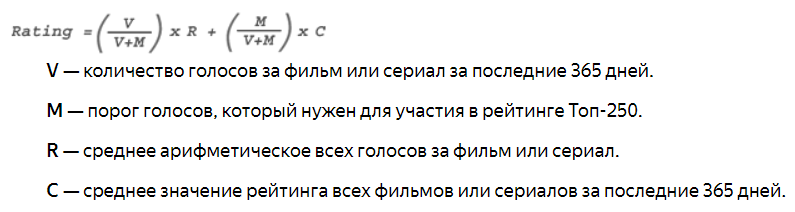

In [ ]:
# def get_top_250(v, r, c, m=500):
#     anime['rating250'] = anime
    
df2 = rating[rating.rating != -1]
v=df2.groupby(by='anime_id').rating.count().to_numpy()
m=np.full((9927,), 500)
r = df2.rating.mean()
c = anime.rating.mean()
df3 = pd.concat([pd.DataFrame((v/(v+m))*r+(m/(v+m))*c),
           df2.groupby(by='anime_id').rating.count().reset_index()], axis=1).rename(columns={0:'rating250'})
df3 = df3[['anime_id', 'rating250']].sort_values(by='rating250', ascending=False)[:250]
pd.merge(df3, anime).drop_duplicates('name').head(20)

## The most contradictory titles 🤨
The idea is to get titles with the highest std for rating.

In [ ]:
rating = rating[rating.rating != -1]
std = rating.groupby(by='anime_id').rating.std().reset_index(name='rating_std')
pd.merge(std, anime[(anime.members >= 10000)&
                    (~anime.genre.isin(['Hentai', 'Yaoi', 'Yuri', 'Ecchi', 'Harem', 'Music']))&
                    (anime.rating >=7)&
                    (anime.type.isin(['TV', 'Movie']))]).drop_duplicates('name').sort_values(by='rating_std', ascending=False)[10:30]

## The most unambiguous titles 😎🏆

In [ ]:
# rating = rating[rating.rating != -1]
# std = rating.groupby(by='anime_id').rating.std().reset_index(name='rating_std')
pd.merge(std, anime[(anime.members >= 10000)&
                    (~anime.genre.isin(['Hentai', 'Yaoi', 'Yuri', 'Ecchi', 'Harem', 'Music']))&
                    (anime.rating >=7)&
                    (anime.type.isin(['TV', 'Movie']))]).drop_duplicates('name').sort_values(by='rating_std')[:20]

## The most popular genres 🖼
Genres with the biggest amount of users watched it.

In [ ]:
genres = anime.copy()
genres.genre = genres.genre.str.split(', ').explode('genre')
genres

In [ ]:
pop_genres = pd.merge(rating[['user_id', 'anime_id']], genres, on='anime_id')
pop_genres = pop_genres.groupby(by='genre').user_id.agg(count='count',
                                           percentage=lambda x: round(x.count()/len(pop_genres)*100,2))
pop_genres.sort_values(by='percentage', ascending=False)

In [ ]:
temp = pd.DataFrame(pop_genres[~(pop_genres.percentage >= 5)].sum()).rename(columns={0:'Other genres'}).T
pd.concat([temp,
           pop_genres[pop_genres.percentage >= 5]])[['count']].plot(kind='pie',
                                                                    y='count',
                                                                    autopct='%1.0f%%')

## Genres with the highest rating 💯

In [ ]:
genres = pd.DataFrame(anime.genre.drop_duplicates().reset_index(drop=True))
genres

In [ ]:
anime.groupby(by='genre').rating.mean().sort_values()

In [ ]:
pd.merge(anime, rating, on='anime_id').groupby(by='genre').user_id.count().sort_values(ascending=False)[:10]

# Recommendation System 🌆